In [2]:
import numpy as np
import numba

N_states = 2+2

R =  0.1
L_s =  0.01
K_p = 0.1
T_pi = 0.1
Phi = 1.0
omega_e = 2*np.pi*50

struct = np.rec.array([(np.zeros((N_states,1)),
                        np.zeros((N_states,1)),
                        R,
                        L_s,
                        Phi,
                        0.0,  # v_d
                        0.0,  # v_q
                        0.0,  # omega_e
                        K_p,
                        T_pi,
                        0.0,
                        0.0
                        )],
                       dtype=[('x', np.float64,(N_states,1)),
                              ('f', np.float64,(N_states,1)),
                              ('R', np.float64),
                              ('L_s', np.float64),
                              ('Phi', np.float64),
                              ('v_d', np.float64),
                              ('v_q', np.float64),
                              ('omega_e', np.float64),
                              ('K_p', np.float64),
                              ('T_pi', np.float64),
                              ('i_d_ref', np.float64),
                              ('i_q_ref', np.float64)
                             ])

In [14]:
@numba.njit(cache=True)
def f_eval(struct):
    L_s = struct[0].L_s
    R = struct[0].R
    Phi = struct[0].Phi
    omega_e = struct[0].omega_e
    K_p = struct[0].K_p
    T_pi = struct[0].T_pi
    i_d_ref = struct[0].i_d_ref
    i_q_ref = struct[0].i_q_ref
    
    i_d  = struct[0].x[0,0]
    i_q  = struct[0].x[1,0]
    xi_d = struct[0].x[2,0]
    xi_q = struct[0].x[3,0]
    
    # control begins
    error_d = i_d_ref - i_d
    error_q = i_q_ref - i_q
    
    u_d = K_p*(error_d + 1.0/T_pi*xi_d)
    u_q = K_p*(error_q + 1.0/T_pi*xi_q)
    
    v_d = u_d - L_s*omega_e*i_q 
    v_q = u_q + L_s*omega_e*i_q + omega_e*Phi
    # control ends
    
    
    
    struct[0].f[0,0] =  1.0/L_s*(v_d + L_s*omega_e*i_q - R*i_d)
    struct[0].f[1,0] =  1.0/L_s*(v_q - L_s*omega_e*i_d - omega_e*Phi- R*i_q)
    struct[0].f[2,0] =  error_d
    struct[0].f[3,0] =  error_q
    
    
    struct[0].v_d = v_d
    struct[0].v_q = v_q

    
@numba.njit(cache=True)
def perturbation(t,struct):
    struct[0].i_d_ref =  0.0
    struct[0].i_q_ref =  0.0
    
    if t>1.0:
        struct[0].i_d_ref = 10.0
    if t>2.0:
        struct[0].i_q_ref = 5.0    

In [18]:
@numba.njit(cache=True)
def solver(struct):
    x_0 = 0.0
    Dt = 1.0e-3
    N_steps = 4000
    N_states = 4
    N_outs = 2
    T = np.zeros(N_steps)
    X = np.zeros((N_steps,N_states))
    Y = np.zeros((N_steps,N_outs))
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0,0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        perturbation(t,struct)
        # euler solver
        f_eval(struct)
        struct[0].x[:,0] += Dt*struct[0].f[:,0]
        
        # channels
        T[it+1] = t
        X[it+1,0] = struct[0].x[0,0]   
        X[it+1,1] = struct[0].x[1,0]  
        X[it+1,2] = struct[0].x[2,0]   
        X[it+1,3] = struct[0].x[3,0] 
        Y[it+1,0] = struct[0].v_d
        Y[it+1,1] = struct[0].v_q
        
    return T,X,Y

# with hyper: 1.42 ms ± 9.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# without hyper: 1.41 ms ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [19]:
%timeit T,X,Y = solver(struct)
T,X,Y = solver(struct)

698 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Output plot

<IPython.core.display.Javascript object>


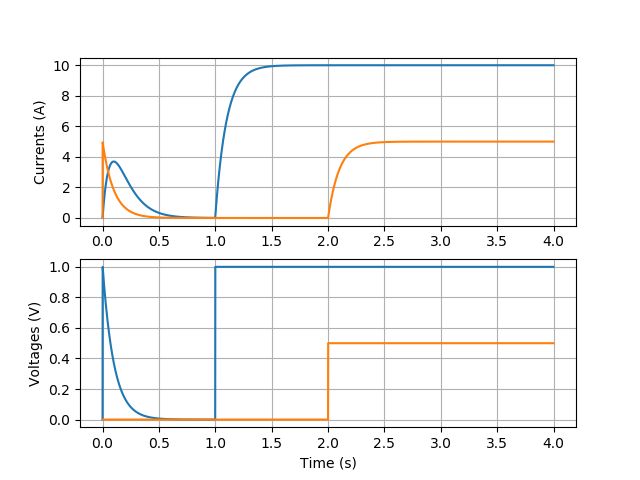

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('')

fig, (ax0,ax1) = plt.subplots(nrows=2)   # creates a figure with one axe
ax0.plot(T,X[:,0])
ax0.plot(T,X[:,1])
ax1.plot(T,Y[:,0])
ax1.plot(T,Y[:,1])

#ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Currents (A)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltages (V)')

ax0.grid(True)
ax1.grid(True)
plt.show()

In [33]:
@numba.njit(cache=True)
def solver_trapz(struct):
    x_0 = 0.0
    Dt = 4.0e-3
    N_steps = 1000
    N_states = 4
    N_outs = 2
    T = np.zeros(N_steps)
    X = np.zeros((N_steps,N_states))
    Y = np.zeros((N_steps,N_outs))
    
    t = 0.0
    struct[0].x[0,0] = x_0
    T[0] = t
    X[0,0] = struct[0].x[0,0]
    for it in range(N_steps-1):
        t += Dt
        perturbation(t,struct)        
        f_eval(struct)
        x_left = np.copy(struct[0].x[:,0])
        f_left = np.copy(struct[0].f[:,0])
        struct[0].x[:,0] = x_left + Dt * f_left
        f_eval(struct)
        struct[0].x[:,0] = x_left + 0.5*Dt*(f_left + struct[0].f[:,0])
           
        # channels
        T[it+1] = t
        X[it+1,0] = struct[0].x[0,0]   
        X[it+1,1] = struct[0].x[1,0]  
        X[it+1,2] = struct[0].x[2,0]   
        X[it+1,3] = struct[0].x[3,0] 
        Y[it+1,0] = struct[0].v_d
        Y[it+1,1] = struct[0].v_q
        
    return T,X,Y

In [34]:
%timeit T_trapz,X_trapz, Y_trapz = solver_trapz(struct)
T_trapz,X_trapz,Y_trapz = solver_trapz(struct)

417 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


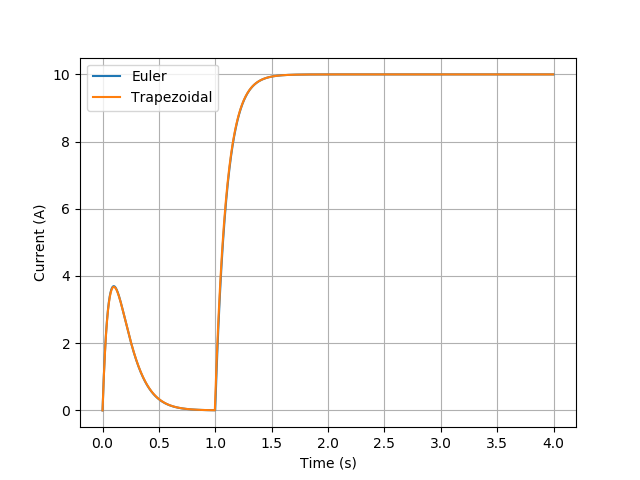

In [35]:
fig, (ax0) = plt.subplots(nrows=1)   # creates a figure with one axe
#ax0.plot(T_trapz,exact(T_trapz), label='Exact')
ax0.plot(T,X[:,0], label='Euler')
ax0.plot(T_trapz,X_trapz[:,0], label='Trapezoidal')
ax0.set_xlabel('Time (s)')
ax0.set_ylabel('Current (A)')
ax0.grid()
ax0.legend()
plt.show()